# Tests for study rules

In [1]:
from tqdm import tqdm

In [2]:
from matplotlib import pyplot as plt

In [3]:
import json

In [4]:
from datetime import datetime, timedelta

In [5]:
import requests

In [6]:
import pandas as pd

In [7]:
from influenzanet.api.management_api import ManagementAPIClient

Fill this object using the credential of a staging platform you own:

In [8]:
credentials = {
    "management_api_url": "",
    "participant_api_url": "",
    "login_credentials": {
        "email": "",
        "password": "",
        "instanceId": "",
    }
}

Fill these variables with a `profile_id`/`participant_id` present on your staging infrastructure.

In [9]:
profile_id = ''
participant_id = ''

In [10]:
def login():
    global api
    
    try:
        api.renew_token()
    except:
        api = ManagementAPIClient(**credentials, verbose=False)
    
    return api

In [11]:
def run_rule(rule, participant_id=participant_id):
    """
    Run a custom rule against a `participant_id`. If `rule` is a dict it is used
    directly, otherwise a file named `rule` is searched among the defined custom rules
    for the study
    """
    api = login()

    if type(rule) is str:
        rules_path = "../output/verdi/customRules"
        rule_file = f"{rules_path}/{rule}.json"
        with open(rule_file) as f:
            rule = json.load(f)

    api.run_custom_study_rules_for_single_participant("common", rule, participant_id)

In [12]:
def get_reports(reportKey, profile_id=profile_id):
    """
    Download reports with key `reportKey` for `profile_id`
    """
    api = login()
    
    reports = requests.get(
        f"{credentials['participant_api_url']}/v1/reports",
        headers=api.auth_header,
        params={"profileId": profile_id, "reportKey": reportKey},
    ).json()

    if "reports" not in reports:
        return pd.DataFrame()
    
    dates = pd.DataFrame(
        [
            {data["key"]: data["value"] for data in report["data"]}
            for report in reports["reports"]
        ]
    )

    for col in dates.columns:
        dates[col] = pd.to_datetime(dates[col].astype(float), unit="s")

    dates = dates.sort_values('referenceDate').reset_index(drop=True)
        
    return dates

In [13]:
def setTestDate(testDate):
    """
    Set `intervalTestDate` to `testDate`
    """
    timestamp = int(datetime.timestamp(testDate))

    rule = {
        "name": "DO",
        "data": [
            {
                "dtype": "exp",
                "exp": {
                    "name": "UPDATE_FLAG",
                    "data": [
                        {"dtype": "str", "str": "intervalTestDate"},
                        {
                            "dtype": "exp",
                            "exp": {
                                "name": "timestampWithOffset",
                                "data": [
                                    {"dtype": "num", "num": 0},
                                    {"dtype": "num", "num": timestamp},
                                ],
                            },
                        },
                    ],
                },
            }
        ],
    }

    return [rule]

## Test entry, reassign, expire rules

Starting from today, for each day in the following 365 days, simulate:

1. study entry
2. survey reassign (1 week after the first assignation)
3. survey expire (4 weeks after the second assignation)

Each rule stores the dates of interest into a participant report.

In [14]:
testDate = datetime.now()
run_rule("testCleanupTestDate")
run_rule("testCleanupIntervalAndSurvey")
for i in tqdm(range(365)):
    run_rule(setTestDate(testDate))
    run_rule("testEntryRule")
    run_rule("testReassignRule")
    run_rule("testExpireRule")
    run_rule("testCleanupIntervalAndSurvey")
    testDate += timedelta(days=1)
run_rule("testCleanupTestDate")
run_rule("testCleanupIntervalAndSurvey")

  0% 0/365 [00:00<?, ?it/s]

  0% 1/365 [00:00<04:39,  1.30it/s]

  1% 2/365 [00:01<04:36,  1.31it/s]

  1% 3/365 [00:02<04:25,  1.36it/s]

  1% 4/365 [00:02<04:21,  1.38it/s]

  1% 5/365 [00:03<04:24,  1.36it/s]

  2% 6/365 [00:04<04:21,  1.37it/s]

  2% 7/365 [00:05<04:11,  1.42it/s]

  2% 8/365 [00:05<04:03,  1.46it/s]

  2% 9/365 [00:06<03:58,  1.50it/s]

  3% 10/365 [00:06<03:56,  1.50it/s]

  3% 11/365 [00:07<03:54,  1.51it/s]

  3% 12/365 [00:08<03:51,  1.52it/s]

  4% 13/365 [00:08<03:52,  1.51it/s]

  4% 14/365 [00:09<04:00,  1.46it/s]

  4% 15/365 [00:10<04:11,  1.39it/s]

  4% 16/365 [00:11<04:19,  1.34it/s]

  5% 17/365 [00:12<04:21,  1.33it/s]

  5% 18/365 [00:12<04:15,  1.36it/s]

  5% 19/365 [00:13<04:10,  1.38it/s]

  5% 20/365 [00:14<04:09,  1.38it/s]

  6% 21/365 [00:14<04:11,  1.37it/s]

  6% 22/365 [00:15<04:16,  1.33it/s]

  6% 23/365 [00:16<04:13,  1.35it/s]

  7% 24/365 [00:17<04:06,  1.38it/s]

  7% 25/365 [00:17<04:02,  1.40it/s]

  7% 26/365 [00:18<04:00,  1.41it/s]

  7% 27/365 [00:19<04:06,  1.37it/s]

  8% 28/365 [00:20<04:15,  1.32it/s]

  8% 29/365 [00:20<04:07,  1.36it/s]

  8% 30/365 [00:21<04:11,  1.33it/s]

  8% 31/365 [00:22<04:02,  1.38it/s]

  9% 32/365 [00:22<03:48,  1.46it/s]

  9% 33/365 [00:23<03:43,  1.48it/s]

  9% 34/365 [00:24<03:36,  1.53it/s]

 10% 35/365 [00:24<03:34,  1.54it/s]

 10% 36/365 [00:25<03:29,  1.57it/s]

 10% 37/365 [00:26<03:32,  1.54it/s]

 10% 38/365 [00:26<03:41,  1.48it/s]

 11% 39/365 [00:27<03:41,  1.47it/s]

 11% 40/365 [00:28<03:51,  1.40it/s]

 11% 41/365 [00:28<03:47,  1.42it/s]

 12% 42/365 [00:29<03:48,  1.41it/s]

 12% 43/365 [00:30<04:01,  1.33it/s]

 12% 44/365 [00:31<03:50,  1.39it/s]

 12% 45/365 [00:31<03:48,  1.40it/s]

 13% 46/365 [00:32<03:39,  1.45it/s]

 13% 47/365 [00:33<03:34,  1.49it/s]

 13% 48/365 [00:33<03:34,  1.48it/s]

 13% 49/365 [00:34<03:32,  1.49it/s]

 14% 50/365 [00:35<03:37,  1.45it/s]

 14% 51/365 [00:35<03:42,  1.41it/s]

 14% 52/365 [00:36<03:45,  1.39it/s]

 15% 53/365 [00:37<03:48,  1.37it/s]

 15% 54/365 [00:38<03:48,  1.36it/s]

 15% 55/365 [00:38<03:46,  1.37it/s]

 15% 56/365 [00:39<03:47,  1.36it/s]

 16% 57/365 [00:40<03:53,  1.32it/s]

 16% 58/365 [00:41<03:49,  1.34it/s]

 16% 59/365 [00:41<03:52,  1.32it/s]

 16% 60/365 [00:42<03:47,  1.34it/s]

 17% 61/365 [00:43<03:42,  1.37it/s]

 17% 62/365 [00:44<03:40,  1.37it/s]

 17% 63/365 [00:44<03:38,  1.38it/s]

 18% 64/365 [00:45<03:38,  1.38it/s]

 18% 65/365 [00:46<03:40,  1.36it/s]

 18% 66/365 [00:47<03:37,  1.37it/s]

 18% 67/365 [00:47<03:32,  1.41it/s]

 19% 68/365 [00:48<03:29,  1.42it/s]

 19% 69/365 [00:49<03:29,  1.41it/s]

 19% 70/365 [00:49<03:38,  1.35it/s]

 19% 71/365 [00:50<03:33,  1.38it/s]

 20% 72/365 [00:51<03:35,  1.36it/s]

 20% 73/365 [00:52<03:37,  1.34it/s]

 20% 74/365 [00:52<03:31,  1.37it/s]

 21% 75/365 [00:53<03:29,  1.38it/s]

 21% 76/365 [00:54<03:31,  1.37it/s]

 21% 77/365 [00:55<03:29,  1.37it/s]

 21% 78/365 [00:55<03:29,  1.37it/s]

 22% 79/365 [00:56<03:24,  1.40it/s]

 22% 80/365 [00:57<03:26,  1.38it/s]

 22% 81/365 [00:57<03:24,  1.39it/s]

 22% 82/365 [00:58<03:23,  1.39it/s]

 23% 83/365 [00:59<03:24,  1.38it/s]

 23% 84/365 [01:00<03:28,  1.35it/s]

 23% 85/365 [01:00<03:25,  1.36it/s]

 24% 86/365 [01:01<03:16,  1.42it/s]

 24% 87/365 [01:02<03:11,  1.45it/s]

 24% 88/365 [01:02<03:09,  1.46it/s]

 24% 89/365 [01:03<03:06,  1.48it/s]

 25% 90/365 [01:04<03:01,  1.52it/s]

 25% 91/365 [01:04<02:59,  1.52it/s]

 25% 92/365 [01:05<02:56,  1.54it/s]

 25% 93/365 [01:06<03:05,  1.46it/s]

 26% 94/365 [01:06<03:07,  1.45it/s]

 26% 95/365 [01:07<03:10,  1.42it/s]

 26% 96/365 [01:08<03:11,  1.41it/s]

 27% 97/365 [01:08<03:08,  1.42it/s]

 27% 98/365 [01:09<03:14,  1.37it/s]

 27% 99/365 [01:10<03:10,  1.40it/s]

 27% 100/365 [01:11<03:10,  1.39it/s]

 28% 101/365 [01:11<03:10,  1.39it/s]

 28% 102/365 [01:12<03:08,  1.40it/s]

 28% 103/365 [01:13<03:05,  1.41it/s]

 28% 104/365 [01:13<03:04,  1.42it/s]

 29% 105/365 [01:14<03:06,  1.40it/s]

 29% 106/365 [01:15<03:07,  1.38it/s]

 29% 107/365 [01:16<03:15,  1.32it/s]

 30% 108/365 [01:16<03:07,  1.37it/s]

 30% 109/365 [01:17<03:04,  1.39it/s]

 30% 110/365 [01:18<03:03,  1.39it/s]

 30% 111/365 [01:19<03:04,  1.37it/s]

 31% 112/365 [01:19<03:10,  1.33it/s]

 31% 113/365 [01:20<03:06,  1.35it/s]

 31% 114/365 [01:21<03:07,  1.34it/s]

 32% 115/365 [01:22<03:06,  1.34it/s]

 32% 116/365 [01:22<03:05,  1.34it/s]

 32% 117/365 [01:39<23:11,  5.61s/it]

 32% 118/365 [01:40<17:04,  4.15s/it]

 33% 119/365 [01:41<12:51,  3.14s/it]

 33% 120/365 [01:42<09:52,  2.42s/it]

 33% 121/365 [01:42<07:44,  1.90s/it]

 33% 122/365 [01:43<06:18,  1.56s/it]

 34% 123/365 [01:44<05:17,  1.31s/it]

 34% 124/365 [01:44<04:30,  1.12s/it]

 34% 125/365 [01:45<04:04,  1.02s/it]

 35% 126/365 [01:46<03:43,  1.07it/s]

 35% 127/365 [01:47<03:29,  1.14it/s]

 35% 128/365 [02:04<22:23,  5.67s/it]

 35% 129/365 [02:04<16:25,  4.18s/it]

 36% 130/365 [02:05<12:17,  3.14s/it]

 36% 131/365 [02:06<09:21,  2.40s/it]

 36% 132/365 [02:06<07:21,  1.90s/it]

 36% 133/365 [02:07<05:57,  1.54s/it]

 37% 134/365 [02:08<05:02,  1.31s/it]

 37% 135/365 [02:09<04:25,  1.15s/it]

 37% 136/365 [02:09<03:55,  1.03s/it]

 38% 137/365 [02:10<03:34,  1.06it/s]

 38% 138/365 [02:11<03:23,  1.12it/s]

 38% 139/365 [02:12<03:12,  1.18it/s]

 38% 140/365 [02:12<02:59,  1.25it/s]

 39% 141/365 [02:13<02:58,  1.26it/s]

 39% 142/365 [02:14<02:52,  1.30it/s]

 39% 143/365 [02:15<02:43,  1.36it/s]

 39% 144/365 [02:15<02:39,  1.39it/s]

 40% 145/365 [02:16<02:34,  1.43it/s]

 40% 146/365 [02:17<02:30,  1.45it/s]

 40% 147/365 [02:17<02:26,  1.48it/s]

 41% 148/365 [02:18<02:24,  1.50it/s]

 41% 149/365 [02:18<02:17,  1.57it/s]

 41% 150/365 [02:19<02:26,  1.47it/s]

 41% 151/365 [02:20<02:28,  1.45it/s]

 42% 152/365 [02:21<02:30,  1.42it/s]

 42% 153/365 [02:21<02:39,  1.33it/s]

 42% 154/365 [02:22<02:34,  1.36it/s]

 42% 155/365 [02:23<02:31,  1.39it/s]

 43% 156/365 [02:24<02:30,  1.39it/s]

 43% 157/365 [02:24<02:29,  1.39it/s]

 43% 158/365 [02:25<02:27,  1.40it/s]

 44% 159/365 [02:26<02:28,  1.39it/s]

 44% 160/365 [02:26<02:25,  1.41it/s]

 44% 161/365 [02:27<02:23,  1.42it/s]

 44% 162/365 [02:28<02:25,  1.40it/s]

 45% 163/365 [02:29<02:22,  1.42it/s]

 45% 164/365 [02:29<02:28,  1.35it/s]

 45% 165/365 [02:30<02:28,  1.35it/s]

 45% 166/365 [02:31<02:29,  1.33it/s]

 46% 167/365 [02:32<02:27,  1.34it/s]

 46% 168/365 [02:32<02:23,  1.37it/s]

 46% 169/365 [02:33<02:20,  1.40it/s]

 47% 170/365 [02:34<02:21,  1.38it/s]

 47% 171/365 [02:34<02:18,  1.40it/s]

 47% 172/365 [02:35<02:19,  1.38it/s]

 47% 173/365 [02:36<02:20,  1.37it/s]

 48% 174/365 [02:37<02:19,  1.37it/s]

 48% 175/365 [02:37<02:17,  1.38it/s]

 48% 176/365 [02:38<02:15,  1.40it/s]

 48% 177/365 [02:39<02:20,  1.34it/s]

 49% 178/365 [02:40<02:21,  1.33it/s]

 49% 179/365 [02:40<02:15,  1.37it/s]

 49% 180/365 [02:41<02:11,  1.41it/s]

 50% 181/365 [02:42<02:06,  1.45it/s]

 50% 182/365 [02:42<02:03,  1.48it/s]

 50% 183/365 [02:43<02:02,  1.49it/s]

 50% 184/365 [02:44<01:58,  1.52it/s]

 51% 185/365 [02:44<01:56,  1.54it/s]

 51% 186/365 [02:45<01:58,  1.51it/s]

 51% 187/365 [02:46<02:01,  1.47it/s]

 52% 188/365 [02:46<02:01,  1.46it/s]

 52% 189/365 [02:47<02:07,  1.38it/s]

 52% 190/365 [02:48<02:05,  1.40it/s]

 52% 191/365 [02:48<02:03,  1.41it/s]

 53% 192/365 [02:49<02:07,  1.36it/s]

 53% 193/365 [02:50<02:05,  1.37it/s]

 53% 194/365 [02:51<02:07,  1.34it/s]

 53% 195/365 [02:52<02:08,  1.32it/s]

 54% 196/365 [02:52<02:06,  1.34it/s]

 54% 197/365 [02:53<02:02,  1.37it/s]

 54% 198/365 [02:54<02:02,  1.36it/s]

 55% 199/365 [02:54<02:02,  1.36it/s]

 55% 200/365 [02:55<02:01,  1.36it/s]

 55% 201/365 [02:56<01:59,  1.37it/s]

 55% 202/365 [02:57<01:57,  1.38it/s]

 56% 203/365 [02:57<01:55,  1.40it/s]

 56% 204/365 [02:58<01:52,  1.44it/s]

 56% 205/365 [02:59<01:48,  1.47it/s]

 56% 206/365 [02:59<01:50,  1.44it/s]

 57% 207/365 [03:00<01:50,  1.43it/s]

 57% 208/365 [03:01<01:45,  1.49it/s]

 57% 209/365 [03:01<01:43,  1.50it/s]

 58% 210/365 [03:02<01:45,  1.47it/s]

 58% 211/365 [03:03<01:46,  1.44it/s]

 58% 212/365 [03:03<01:46,  1.44it/s]

 58% 213/365 [03:04<01:47,  1.42it/s]

 59% 214/365 [03:05<01:50,  1.37it/s]

 59% 215/365 [03:06<01:50,  1.36it/s]

 59% 216/365 [03:06<01:47,  1.39it/s]

 59% 217/365 [03:07<01:44,  1.41it/s]

 60% 218/365 [03:08<01:44,  1.41it/s]

 60% 219/365 [03:08<01:41,  1.43it/s]

 60% 220/365 [03:09<01:46,  1.36it/s]

 61% 221/365 [03:10<01:45,  1.37it/s]

 61% 222/365 [03:11<01:46,  1.34it/s]

 61% 223/365 [03:12<01:46,  1.33it/s]

 61% 224/365 [03:12<01:43,  1.36it/s]

 62% 225/365 [03:13<01:40,  1.40it/s]

 62% 226/365 [03:14<01:38,  1.41it/s]

 62% 227/365 [03:14<01:37,  1.42it/s]

 62% 228/365 [03:15<01:39,  1.38it/s]

 63% 229/365 [03:16<01:38,  1.38it/s]

 63% 230/365 [03:16<01:35,  1.41it/s]

 63% 231/365 [03:17<01:35,  1.41it/s]

 64% 232/365 [03:18<01:35,  1.39it/s]

 64% 233/365 [03:19<01:32,  1.43it/s]

 64% 234/365 [03:19<01:34,  1.38it/s]

 64% 235/365 [03:20<01:34,  1.37it/s]

 65% 236/365 [03:21<01:36,  1.33it/s]

 65% 237/365 [03:22<01:35,  1.34it/s]

 65% 238/365 [03:22<01:33,  1.35it/s]

 65% 239/365 [03:23<01:41,  1.24it/s]

 66% 240/365 [03:25<02:17,  1.10s/it]

 66% 241/365 [03:26<02:01,  1.02it/s]

 66% 242/365 [03:26<01:49,  1.12it/s]

 67% 243/365 [03:27<01:41,  1.20it/s]

 67% 244/365 [03:28<01:38,  1.23it/s]

 67% 245/365 [03:29<01:35,  1.25it/s]

 67% 246/365 [03:30<01:34,  1.26it/s]

 68% 247/365 [03:30<01:35,  1.24it/s]

 68% 248/365 [03:31<01:32,  1.27it/s]

 68% 249/365 [03:32<01:27,  1.32it/s]

 68% 250/365 [03:32<01:24,  1.36it/s]

 69% 251/365 [03:33<01:23,  1.36it/s]

 69% 252/365 [03:34<01:21,  1.38it/s]

 69% 253/365 [03:35<01:20,  1.38it/s]

 70% 254/365 [03:35<01:20,  1.37it/s]

 70% 255/365 [03:36<01:20,  1.37it/s]

 70% 256/365 [03:37<01:18,  1.39it/s]

 70% 257/365 [03:37<01:16,  1.41it/s]

 71% 258/365 [03:38<01:15,  1.41it/s]

 71% 259/365 [03:39<01:17,  1.36it/s]

 71% 260/365 [03:40<01:16,  1.38it/s]

 72% 261/365 [03:40<01:14,  1.39it/s]

 72% 262/365 [03:41<01:16,  1.34it/s]

 72% 263/365 [03:42<01:15,  1.34it/s]

 72% 264/365 [03:43<01:13,  1.38it/s]

 73% 265/365 [03:43<01:11,  1.39it/s]

 73% 266/365 [03:44<01:11,  1.39it/s]

 73% 267/365 [03:45<01:10,  1.40it/s]

 73% 268/365 [03:45<01:09,  1.39it/s]

 74% 269/365 [03:46<01:08,  1.39it/s]

 74% 270/365 [04:03<08:42,  5.50s/it]

 74% 271/365 [04:04<06:22,  4.07s/it]

 75% 272/365 [04:04<04:43,  3.05s/it]

 75% 273/365 [04:05<03:37,  2.36s/it]

 75% 274/365 [04:06<02:49,  1.86s/it]

 75% 275/365 [04:06<02:15,  1.51s/it]

 76% 276/365 [04:07<01:53,  1.28s/it]

 76% 277/365 [04:08<01:36,  1.10s/it]

 76% 278/365 [04:08<01:24,  1.03it/s]

 76% 279/365 [04:09<01:19,  1.08it/s]

 77% 280/365 [04:26<07:50,  5.54s/it]

 77% 281/365 [04:26<05:43,  4.09s/it]

 77% 282/365 [04:27<04:16,  3.09s/it]

 78% 283/365 [04:28<03:14,  2.37s/it]

 78% 284/365 [04:28<02:31,  1.87s/it]

 78% 285/365 [04:29<02:02,  1.54s/it]

 78% 286/365 [04:30<01:41,  1.29s/it]

 79% 287/365 [04:31<01:26,  1.11s/it]

 79% 288/365 [04:31<01:16,  1.01it/s]

 79% 289/365 [04:32<01:10,  1.08it/s]

 79% 290/365 [04:33<01:04,  1.17it/s]

 80% 291/365 [04:33<01:00,  1.23it/s]

 80% 292/365 [04:34<00:57,  1.28it/s]

 80% 293/365 [04:35<00:54,  1.32it/s]

 81% 294/365 [04:36<00:53,  1.32it/s]

 81% 295/365 [04:36<00:52,  1.33it/s]

 81% 296/365 [04:37<00:51,  1.35it/s]

 81% 297/365 [04:38<00:49,  1.36it/s]

 82% 298/365 [04:39<00:48,  1.38it/s]

 82% 299/365 [04:40<01:06,  1.00s/it]

 82% 300/365 [04:41<01:07,  1.04s/it]

 82% 301/365 [04:42<01:02,  1.03it/s]

 83% 302/365 [04:43<01:03,  1.01s/it]

 83% 303/365 [04:44<00:58,  1.05it/s]

 83% 304/365 [04:45<00:52,  1.16it/s]

 84% 305/365 [04:46<00:50,  1.18it/s]

 84% 306/365 [04:46<00:46,  1.27it/s]

 84% 307/365 [04:47<00:43,  1.33it/s]

 84% 308/365 [04:48<00:41,  1.36it/s]

 85% 309/365 [04:48<00:40,  1.38it/s]

 85% 310/365 [04:49<00:41,  1.34it/s]

 85% 311/365 [04:50<00:40,  1.34it/s]

 85% 312/365 [04:50<00:38,  1.38it/s]

 86% 313/365 [04:51<00:37,  1.38it/s]

 86% 314/365 [04:52<00:37,  1.37it/s]

 86% 315/365 [04:53<00:35,  1.40it/s]

 87% 316/365 [04:53<00:35,  1.39it/s]

 87% 317/365 [04:54<00:34,  1.38it/s]

 87% 318/365 [04:55<00:34,  1.38it/s]

 87% 319/365 [04:56<00:34,  1.32it/s]

 88% 320/365 [04:56<00:33,  1.35it/s]

 88% 321/365 [04:57<00:32,  1.37it/s]

 88% 322/365 [04:58<00:31,  1.36it/s]

 88% 323/365 [04:58<00:30,  1.39it/s]

 89% 324/365 [04:59<00:30,  1.34it/s]

 89% 325/365 [05:00<00:29,  1.36it/s]

 89% 326/365 [05:01<00:28,  1.39it/s]

 90% 327/365 [05:01<00:27,  1.40it/s]

 90% 328/365 [05:02<00:26,  1.41it/s]

 90% 329/365 [05:03<00:25,  1.39it/s]

 90% 330/365 [05:04<00:25,  1.38it/s]

 91% 331/365 [05:20<03:03,  5.39s/it]

 91% 332/365 [05:21<02:11,  4.00s/it]

 91% 333/365 [05:21<01:36,  3.02s/it]

 92% 334/365 [05:22<01:12,  2.33s/it]

 92% 335/365 [05:23<00:55,  1.84s/it]

 92% 336/365 [05:23<00:43,  1.50s/it]

 92% 337/365 [05:24<00:35,  1.27s/it]

 93% 338/365 [05:25<00:29,  1.11s/it]

 93% 339/365 [05:26<00:25,  1.00it/s]

 93% 340/365 [05:26<00:22,  1.10it/s]

 93% 341/365 [05:27<00:21,  1.14it/s]

 94% 342/365 [05:28<00:18,  1.22it/s]

 94% 343/365 [05:29<00:18,  1.21it/s]

 94% 344/365 [05:29<00:16,  1.25it/s]

 95% 345/365 [05:30<00:15,  1.30it/s]

 95% 346/365 [05:31<00:14,  1.32it/s]

 95% 347/365 [05:32<00:13,  1.35it/s]

 95% 348/365 [05:32<00:12,  1.36it/s]

 96% 349/365 [05:33<00:11,  1.35it/s]

 96% 350/365 [05:34<00:10,  1.38it/s]

 96% 351/365 [05:50<01:16,  5.48s/it]

 96% 352/365 [05:51<00:53,  4.08s/it]

 97% 353/365 [05:52<00:36,  3.07s/it]

 97% 354/365 [05:53<00:25,  2.36s/it]

 97% 355/365 [05:53<00:18,  1.88s/it]

 98% 356/365 [05:54<00:13,  1.54s/it]

 98% 357/365 [05:55<00:10,  1.28s/it]

 98% 358/365 [05:56<00:07,  1.14s/it]

 98% 359/365 [05:56<00:06,  1.01s/it]

 99% 360/365 [05:57<00:04,  1.07it/s]

 99% 361/365 [05:58<00:03,  1.14it/s]

 99% 362/365 [05:58<00:02,  1.23it/s]

 99% 363/365 [05:59<00:01,  1.22it/s]

100% 364/365 [06:00<00:00,  1.25it/s]

100% 365/365 [06:01<00:00,  1.29it/s]

100% 365/365 [06:01<00:00,  1.01it/s]

In [15]:
entryDates = get_reports("testEntryRule")
reassignDates = get_reports("testReassignRule.after")
expireDates = get_reports("testExpireRule.after")

In [16]:
def plotDates(dates, x='referenceDate', y='startDate'):
    """
    Plot dates outlining every 13 week window from the beginning of the year
    """
    
    xQuarters = pd.date_range(
        f"{dates[x].min().year}",
        dates[x].max(),
        freq="13W-MON",
    )

    yQuarters = pd.date_range(
        f"{dates[y].min().year}",
        dates[y].max() + pd.Timedelta(weeks=1),
        freq="13W-MON",
    )

    dates.set_index(x).sort_index()[y].plot(
        figsize=(15, 5), style="x", xticks=xQuarters, yticks=yQuarters, grid=True
    )

    plt.vlines(xQuarters - pd.Timedelta("2W"), *plt.ylim(), colors="green")

Text(0.5, 1.0, 'Entry assignation')

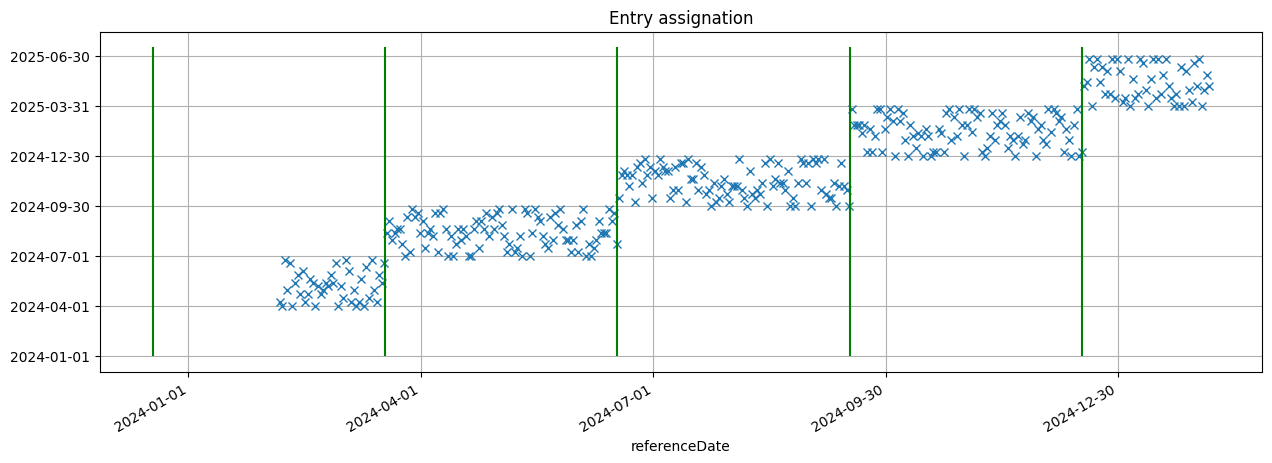

In [17]:
plotDates(entryDates)
plt.title("Entry assignation")

As shown in the above figure, participants are assigned in the next quarter (13
weeks window) wrt the day of enrollment + 2 weeks. The assignation week is
randomized inside the quarter and kept as reference for future assignations.

`startDate` is always on Mondays:

In [18]:
assert entryDates['startDate'].dt.weekday.value_counts().index == [0]

The plot below shows re-assignation dates as a result of running the
re-assignation rule after one week of the first assignation date:

Text(0.5, 1.0, 'Reassignation on submit')

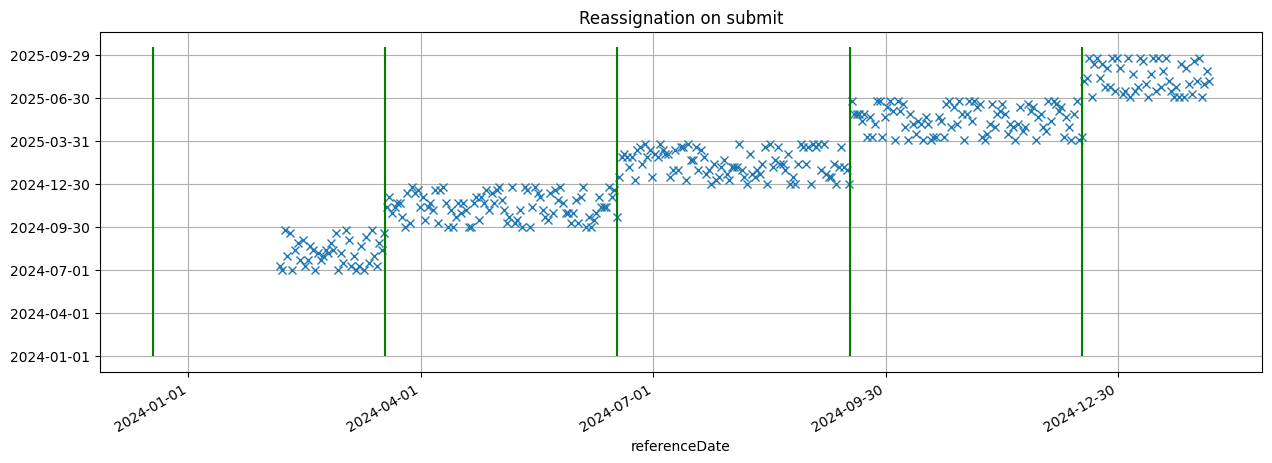

In [19]:
plotDates(reassignDates)
plt.title("Reassignation on submit")

As we can see they are correctly shifted one quarter in the future, always on Mondays:

In [20]:
assert reassignDates['startDate'].dt.weekday.value_counts().index == [0]

The plot below shows re-assignation dates as a result of running the
re-assignation rule after four weeks from the second assignation date (survey expired): 

Text(0.5, 1.0, 'Reassignation on expire')

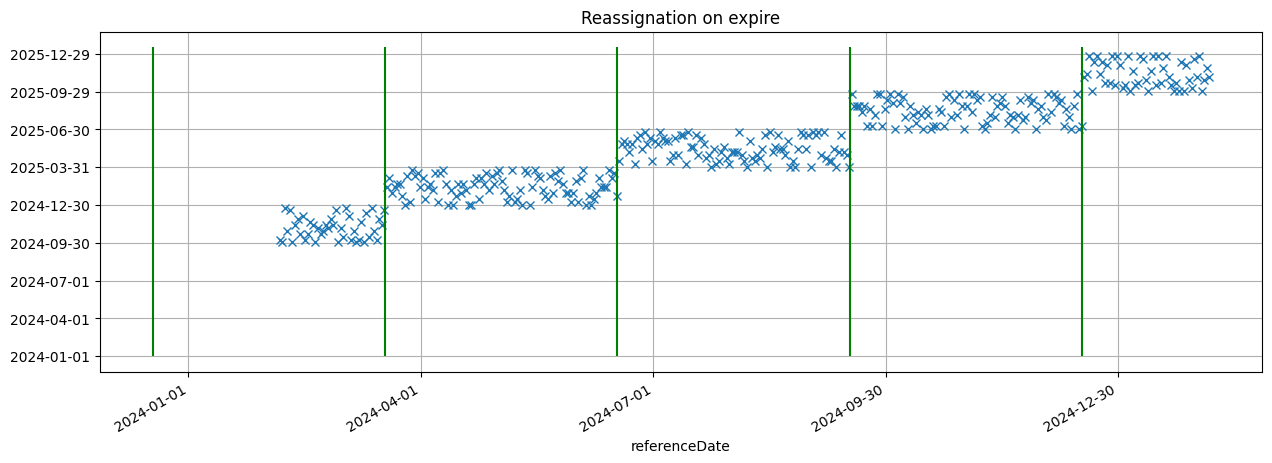

In [21]:
plotDates(expireDates)
plt.title("Reassignation on expire")

As we can see they are correctly shifted one more quarter in the future, always on Mondays:

In [22]:
assert expireDates['startDate'].dt.weekday.value_counts().index == [0]

## Test manual assignation

The rationale behind the manual assignation rule is to assign surveys taking as
reference the start of the current quarter. Surveys will be assigned randomly in
the 13 weeks of the quarter.

Surveys assigned in the past and already expired will be shifted one quarter in
the future by the first timer rule run and so on for other surveys expiring
soon.

Let's check that the manual assignation rules assigns them randomly in the
current quarter:

In [23]:
testDate = datetime.now()
run_rule("testCleanupTestDate")
run_rule("testCleanupIntervalAndSurvey")
for i in tqdm(range(500)):
    run_rule(setTestDate(testDate))
    run_rule("testAssignRule")
    run_rule("testCleanupIntervalAndSurvey")
run_rule("testCleanupTestDate")
run_rule("testCleanupIntervalAndSurvey")

  0% 0/500 [00:00<?, ?it/s]

  0% 1/500 [00:00<03:08,  2.65it/s]

  0% 2/500 [00:00<02:58,  2.79it/s]

  1% 3/500 [00:01<02:51,  2.90it/s]

  1% 4/500 [00:01<02:47,  2.95it/s]

  1% 5/500 [00:01<02:50,  2.91it/s]

  1% 6/500 [00:02<02:53,  2.85it/s]

  1% 7/500 [00:02<02:50,  2.89it/s]

  2% 8/500 [00:02<02:50,  2.88it/s]

  2% 9/500 [00:03<02:48,  2.92it/s]

  2% 10/500 [00:03<02:47,  2.93it/s]

  2% 11/500 [00:03<02:47,  2.91it/s]

  2% 12/500 [00:04<02:49,  2.88it/s]

  3% 13/500 [00:04<02:49,  2.87it/s]

  3% 14/500 [00:04<02:49,  2.87it/s]

  3% 15/500 [00:05<02:49,  2.86it/s]

  3% 16/500 [00:05<02:46,  2.90it/s]

  3% 17/500 [00:05<02:47,  2.88it/s]

  4% 18/500 [00:06<02:54,  2.76it/s]

  4% 19/500 [00:06<02:45,  2.91it/s]

  4% 20/500 [00:06<02:36,  3.07it/s]

  4% 21/500 [00:07<02:29,  3.21it/s]

  4% 22/500 [00:07<02:25,  3.28it/s]

  5% 23/500 [00:07<02:22,  3.36it/s]

  5% 24/500 [00:08<02:24,  3.29it/s]

  5% 25/500 [00:08<02:27,  3.23it/s]

  5% 26/500 [00:08<02:42,  2.92it/s]

  5% 27/500 [00:09<02:35,  3.04it/s]

  6% 28/500 [00:09<02:32,  3.09it/s]

  6% 29/500 [00:09<02:32,  3.08it/s]

  6% 30/500 [00:10<02:27,  3.19it/s]

  6% 31/500 [00:10<02:26,  3.21it/s]

  6% 32/500 [00:10<02:30,  3.12it/s]

  7% 33/500 [00:11<02:33,  3.05it/s]

  7% 34/500 [00:11<02:35,  2.99it/s]

  7% 35/500 [00:11<02:38,  2.93it/s]

  7% 36/500 [00:12<02:43,  2.83it/s]

  7% 37/500 [00:12<02:41,  2.87it/s]

  8% 38/500 [00:12<02:40,  2.88it/s]

  8% 39/500 [00:13<02:39,  2.88it/s]

  8% 40/500 [00:13<02:38,  2.90it/s]

  8% 41/500 [00:13<02:36,  2.94it/s]

  8% 42/500 [00:14<02:35,  2.95it/s]

  9% 43/500 [00:14<02:36,  2.93it/s]

  9% 44/500 [00:14<02:34,  2.95it/s]

  9% 45/500 [00:15<02:34,  2.95it/s]

  9% 46/500 [00:15<02:32,  2.98it/s]

  9% 47/500 [00:15<02:30,  3.00it/s]

 10% 48/500 [00:16<02:41,  2.80it/s]

 10% 49/500 [00:16<02:40,  2.81it/s]

 10% 50/500 [00:16<02:38,  2.84it/s]

 10% 51/500 [00:17<02:44,  2.72it/s]

 10% 52/500 [00:17<02:40,  2.79it/s]

 11% 53/500 [00:18<02:39,  2.80it/s]

 11% 54/500 [00:18<02:37,  2.83it/s]

 11% 55/500 [00:18<02:42,  2.73it/s]

 11% 56/500 [00:35<39:25,  5.33s/it]

 11% 57/500 [00:36<28:47,  3.90s/it]

 12% 58/500 [00:36<20:53,  2.84s/it]

 12% 59/500 [00:36<15:20,  2.09s/it]

 12% 60/500 [00:37<11:27,  1.56s/it]

 12% 61/500 [00:37<08:44,  1.19s/it]

 12% 62/500 [00:37<06:54,  1.06it/s]

 13% 63/500 [00:38<05:37,  1.30it/s]

 13% 64/500 [00:38<04:45,  1.53it/s]

 13% 65/500 [00:39<04:00,  1.81it/s]

 13% 66/500 [00:39<03:36,  2.01it/s]

 13% 67/500 [00:39<03:14,  2.22it/s]

 14% 68/500 [00:40<02:58,  2.42it/s]

 14% 69/500 [00:40<02:55,  2.46it/s]

 14% 70/500 [00:40<02:47,  2.57it/s]

 14% 71/500 [00:41<02:40,  2.67it/s]

 14% 72/500 [00:41<02:34,  2.77it/s]

 15% 73/500 [00:41<02:29,  2.86it/s]

 15% 74/500 [00:42<02:27,  2.89it/s]

 15% 75/500 [00:42<02:28,  2.86it/s]

 15% 76/500 [00:42<02:29,  2.85it/s]

 15% 77/500 [00:43<02:27,  2.86it/s]

 16% 78/500 [00:43<02:27,  2.86it/s]

 16% 79/500 [00:43<02:26,  2.87it/s]

 16% 80/500 [00:44<02:23,  2.93it/s]

 16% 81/500 [00:44<02:22,  2.93it/s]

 16% 82/500 [00:44<02:20,  2.97it/s]

 17% 83/500 [00:45<02:19,  3.00it/s]

 17% 84/500 [00:45<02:19,  2.99it/s]

 17% 85/500 [00:45<02:17,  3.03it/s]

 17% 86/500 [00:46<02:28,  2.80it/s]

 17% 87/500 [00:46<02:25,  2.84it/s]

 18% 88/500 [00:46<02:24,  2.86it/s]

 18% 89/500 [00:47<02:22,  2.88it/s]

 18% 90/500 [00:47<02:21,  2.89it/s]

 18% 91/500 [00:48<02:24,  2.84it/s]

 18% 92/500 [00:48<02:24,  2.82it/s]

 19% 93/500 [00:48<02:26,  2.78it/s]

 19% 94/500 [00:49<02:22,  2.85it/s]

 19% 95/500 [00:49<02:20,  2.87it/s]

 19% 96/500 [00:49<02:19,  2.90it/s]

 19% 97/500 [00:50<02:19,  2.90it/s]

 20% 98/500 [00:50<02:17,  2.92it/s]

 20% 99/500 [00:50<02:17,  2.91it/s]

 20% 100/500 [00:51<02:16,  2.93it/s]

 20% 101/500 [00:51<02:19,  2.85it/s]

 20% 102/500 [00:51<02:17,  2.90it/s]

 21% 103/500 [00:52<02:16,  2.90it/s]

 21% 104/500 [00:52<02:15,  2.92it/s]

 21% 105/500 [00:52<02:21,  2.79it/s]

 21% 106/500 [00:53<02:21,  2.79it/s]

 21% 107/500 [00:53<02:18,  2.84it/s]

 22% 108/500 [00:53<02:16,  2.87it/s]

 22% 109/500 [00:54<02:17,  2.84it/s]

 22% 110/500 [00:54<02:18,  2.82it/s]

 22% 111/500 [00:54<02:16,  2.85it/s]

 22% 112/500 [00:55<02:16,  2.84it/s]

 23% 113/500 [00:55<02:22,  2.72it/s]

 23% 114/500 [00:56<02:36,  2.47it/s]

 23% 115/500 [00:56<02:26,  2.63it/s]

 23% 116/500 [00:56<02:21,  2.71it/s]

 23% 117/500 [00:57<02:18,  2.77it/s]

 24% 118/500 [00:57<02:14,  2.83it/s]

 24% 119/500 [00:57<02:12,  2.87it/s]

 24% 120/500 [00:58<02:09,  2.94it/s]

 24% 121/500 [00:58<02:08,  2.95it/s]

 24% 122/500 [00:58<02:02,  3.08it/s]

 25% 123/500 [00:59<01:57,  3.21it/s]

 25% 124/500 [00:59<01:56,  3.23it/s]

 25% 125/500 [00:59<01:53,  3.30it/s]

 25% 126/500 [01:00<01:50,  3.38it/s]

 25% 127/500 [01:00<01:49,  3.41it/s]

 26% 128/500 [01:00<01:48,  3.42it/s]

 26% 129/500 [01:00<01:49,  3.39it/s]

 26% 130/500 [01:01<01:46,  3.46it/s]

 26% 131/500 [01:01<01:46,  3.47it/s]

 26% 132/500 [01:01<01:47,  3.43it/s]

 27% 133/500 [01:02<01:45,  3.47it/s]

 27% 134/500 [01:02<01:44,  3.50it/s]

 27% 135/500 [01:02<01:50,  3.31it/s]

 27% 136/500 [01:03<01:56,  3.12it/s]

 27% 137/500 [01:03<02:03,  2.95it/s]

 28% 138/500 [01:03<02:04,  2.92it/s]

 28% 139/500 [01:04<02:01,  2.96it/s]

 28% 140/500 [01:04<02:04,  2.90it/s]

 28% 141/500 [01:04<02:04,  2.87it/s]

 28% 142/500 [01:05<02:03,  2.91it/s]

 29% 143/500 [01:05<02:01,  2.95it/s]

 29% 144/500 [01:05<02:00,  2.95it/s]

 29% 145/500 [01:06<02:09,  2.74it/s]

 29% 146/500 [01:06<02:07,  2.77it/s]

 29% 147/500 [01:06<02:02,  2.89it/s]

 30% 148/500 [01:07<01:55,  3.04it/s]

 30% 149/500 [01:07<01:51,  3.16it/s]

 30% 150/500 [01:07<01:49,  3.20it/s]

 30% 151/500 [01:08<01:49,  3.19it/s]

 30% 152/500 [01:08<01:52,  3.11it/s]

 31% 153/500 [01:08<01:51,  3.12it/s]

 31% 154/500 [01:09<01:47,  3.20it/s]

 31% 155/500 [01:09<01:45,  3.27it/s]

 31% 156/500 [01:09<01:46,  3.24it/s]

 31% 157/500 [01:09<01:46,  3.22it/s]

 32% 158/500 [01:10<01:44,  3.28it/s]

 32% 159/500 [01:10<01:41,  3.37it/s]

 32% 160/500 [01:10<01:41,  3.34it/s]

 32% 161/500 [01:11<01:53,  2.99it/s]

 32% 162/500 [01:11<01:52,  3.00it/s]

 33% 163/500 [01:11<01:53,  2.98it/s]

 33% 164/500 [01:12<01:54,  2.94it/s]

 33% 165/500 [01:12<01:54,  2.93it/s]

 33% 166/500 [01:12<01:55,  2.88it/s]

 33% 167/500 [01:13<01:58,  2.81it/s]

 34% 168/500 [01:13<02:00,  2.76it/s]

 34% 169/500 [01:14<01:57,  2.81it/s]

 34% 170/500 [01:14<01:56,  2.83it/s]

 34% 171/500 [01:14<01:57,  2.81it/s]

 34% 172/500 [01:15<01:55,  2.85it/s]

 35% 173/500 [01:15<01:52,  2.90it/s]

 35% 174/500 [01:15<01:53,  2.87it/s]

 35% 175/500 [01:16<02:00,  2.70it/s]

 35% 176/500 [01:16<01:56,  2.77it/s]

 35% 177/500 [01:16<01:59,  2.70it/s]

 36% 178/500 [01:17<01:55,  2.78it/s]

 36% 179/500 [01:17<01:55,  2.79it/s]

 36% 180/500 [01:17<01:52,  2.83it/s]

 36% 181/500 [01:18<01:55,  2.77it/s]

 36% 182/500 [01:18<01:57,  2.71it/s]

 37% 183/500 [01:19<01:58,  2.68it/s]

 37% 184/500 [01:19<01:56,  2.72it/s]

 37% 185/500 [01:19<01:51,  2.83it/s]

 37% 186/500 [01:20<01:46,  2.95it/s]

 37% 187/500 [01:20<02:07,  2.46it/s]

 38% 188/500 [01:20<01:55,  2.70it/s]

 38% 189/500 [01:21<01:53,  2.74it/s]

 38% 190/500 [01:21<01:46,  2.92it/s]

 38% 191/500 [01:21<01:41,  3.05it/s]

 38% 192/500 [01:22<01:37,  3.16it/s]

 39% 193/500 [01:22<01:33,  3.28it/s]

 39% 194/500 [01:22<01:36,  3.16it/s]

 39% 195/500 [01:23<01:34,  3.24it/s]

 39% 196/500 [01:23<01:31,  3.34it/s]

 39% 197/500 [01:23<01:29,  3.39it/s]

 40% 198/500 [01:23<01:30,  3.33it/s]

 40% 199/500 [01:24<01:29,  3.38it/s]

 40% 200/500 [01:24<01:27,  3.43it/s]

 40% 201/500 [01:25<01:52,  2.65it/s]

 40% 202/500 [01:25<01:44,  2.84it/s]

 41% 203/500 [01:25<01:39,  2.98it/s]

 41% 204/500 [01:26<01:42,  2.90it/s]

 41% 205/500 [01:26<01:38,  2.98it/s]

 41% 206/500 [01:26<01:35,  3.07it/s]

 41% 207/500 [01:26<01:30,  3.22it/s]

 42% 208/500 [01:27<01:28,  3.30it/s]

 42% 209/500 [01:27<01:28,  3.28it/s]

 42% 210/500 [01:27<01:28,  3.28it/s]

 42% 211/500 [01:28<01:28,  3.27it/s]

 42% 212/500 [01:28<01:31,  3.14it/s]

 43% 213/500 [01:28<01:37,  2.94it/s]

 43% 214/500 [01:29<01:37,  2.93it/s]

 43% 215/500 [01:29<01:36,  2.94it/s]

 43% 216/500 [01:29<01:37,  2.92it/s]

 43% 217/500 [01:30<01:36,  2.93it/s]

 44% 218/500 [01:30<01:35,  2.97it/s]

 44% 219/500 [01:30<01:35,  2.95it/s]

 44% 220/500 [01:31<01:33,  3.00it/s]

 44% 221/500 [01:31<01:33,  2.97it/s]

 44% 222/500 [01:31<01:33,  2.99it/s]

 45% 223/500 [01:32<01:32,  2.99it/s]

 45% 224/500 [01:32<01:32,  2.97it/s]

 45% 225/500 [01:32<01:34,  2.92it/s]

 45% 226/500 [01:33<01:28,  3.08it/s]

 45% 227/500 [01:33<01:26,  3.16it/s]

 46% 228/500 [01:33<01:25,  3.18it/s]

 46% 229/500 [01:34<01:26,  3.12it/s]

 46% 230/500 [01:34<01:25,  3.18it/s]

 46% 231/500 [01:34<01:24,  3.20it/s]

 46% 232/500 [01:35<01:22,  3.26it/s]

 47% 233/500 [01:35<01:21,  3.28it/s]

 47% 234/500 [01:35<01:20,  3.29it/s]

 47% 235/500 [01:36<01:26,  3.06it/s]

 47% 236/500 [01:37<02:46,  1.58it/s]

 47% 237/500 [01:37<02:22,  1.84it/s]

 48% 238/500 [01:38<02:06,  2.07it/s]

 48% 239/500 [01:38<01:56,  2.24it/s]

 48% 240/500 [01:38<01:49,  2.37it/s]

 48% 241/500 [01:39<01:43,  2.51it/s]

 48% 242/500 [01:39<01:39,  2.59it/s]

 49% 243/500 [01:39<01:34,  2.71it/s]

 49% 244/500 [01:40<01:33,  2.73it/s]

 49% 245/500 [01:40<01:30,  2.82it/s]

 49% 246/500 [01:40<01:28,  2.86it/s]

 49% 247/500 [01:41<01:27,  2.91it/s]

 50% 248/500 [01:41<01:25,  2.95it/s]

 50% 249/500 [01:41<01:27,  2.86it/s]

 50% 250/500 [01:42<01:28,  2.83it/s]

 50% 251/500 [01:42<01:28,  2.83it/s]

 50% 252/500 [01:43<01:27,  2.83it/s]

 51% 253/500 [01:43<01:25,  2.89it/s]

 51% 254/500 [01:43<01:25,  2.86it/s]

 51% 255/500 [01:44<01:24,  2.91it/s]

 51% 256/500 [01:44<01:27,  2.80it/s]

 51% 257/500 [01:44<01:25,  2.83it/s]

 52% 258/500 [01:45<01:24,  2.86it/s]

 52% 259/500 [01:45<01:24,  2.85it/s]

 52% 260/500 [01:45<01:30,  2.66it/s]

 52% 261/500 [01:46<01:25,  2.78it/s]

 52% 262/500 [01:46<01:20,  2.95it/s]

 53% 263/500 [01:46<01:17,  3.05it/s]

 53% 264/500 [01:47<01:16,  3.08it/s]

 53% 265/500 [01:47<01:13,  3.20it/s]

 53% 266/500 [01:47<01:12,  3.24it/s]

 53% 267/500 [01:48<01:11,  3.25it/s]

 54% 268/500 [01:48<01:13,  3.14it/s]

 54% 269/500 [01:48<01:14,  3.10it/s]

 54% 270/500 [01:48<01:12,  3.19it/s]

 54% 271/500 [01:49<01:11,  3.22it/s]

 54% 272/500 [01:49<01:15,  3.03it/s]

 55% 273/500 [01:49<01:13,  3.11it/s]

 55% 274/500 [01:50<01:12,  3.10it/s]

 55% 275/500 [01:50<01:14,  3.03it/s]

 55% 276/500 [01:50<01:15,  2.98it/s]

 55% 277/500 [01:51<01:14,  3.01it/s]

 56% 278/500 [01:51<01:13,  3.00it/s]

 56% 279/500 [01:52<01:17,  2.87it/s]

 56% 280/500 [01:52<01:23,  2.64it/s]

 56% 281/500 [01:52<01:22,  2.66it/s]

 56% 282/500 [01:53<01:19,  2.75it/s]

 57% 283/500 [01:53<01:17,  2.79it/s]

 57% 284/500 [01:53<01:15,  2.85it/s]

 57% 285/500 [01:54<01:14,  2.87it/s]

 57% 286/500 [01:54<01:14,  2.87it/s]

 57% 287/500 [01:54<01:14,  2.88it/s]

 58% 288/500 [01:55<01:13,  2.90it/s]

 58% 289/500 [01:55<01:12,  2.91it/s]

 58% 290/500 [01:55<01:17,  2.72it/s]

 58% 291/500 [01:56<01:15,  2.76it/s]

 58% 292/500 [01:56<01:14,  2.77it/s]

 59% 293/500 [01:57<01:14,  2.77it/s]

 59% 294/500 [01:57<01:15,  2.74it/s]

 59% 295/500 [02:13<17:08,  5.02s/it]

 59% 296/500 [02:13<12:16,  3.61s/it]

 59% 297/500 [02:13<08:53,  2.63s/it]

 60% 298/500 [02:14<06:31,  1.94s/it]

 60% 299/500 [02:14<04:52,  1.46s/it]

 60% 300/500 [02:14<03:45,  1.13s/it]

 60% 301/500 [02:15<02:57,  1.12it/s]

 60% 302/500 [02:15<02:22,  1.39it/s]

 61% 303/500 [02:16<02:03,  1.59it/s]

 61% 304/500 [02:16<01:44,  1.87it/s]

 61% 305/500 [02:16<01:30,  2.16it/s]

 61% 306/500 [02:16<01:19,  2.44it/s]

 61% 307/500 [02:17<01:11,  2.69it/s]

 62% 308/500 [02:17<01:06,  2.88it/s]

 62% 309/500 [02:17<01:03,  3.01it/s]

 62% 310/500 [02:18<01:00,  3.16it/s]

 62% 311/500 [02:18<00:59,  3.19it/s]

 62% 312/500 [02:18<00:59,  3.14it/s]

 63% 313/500 [02:19<00:57,  3.24it/s]

 63% 314/500 [02:19<00:56,  3.29it/s]

 63% 315/500 [02:19<00:57,  3.24it/s]

 63% 316/500 [02:19<00:55,  3.34it/s]

 63% 317/500 [02:20<00:56,  3.22it/s]

 64% 318/500 [02:20<00:55,  3.28it/s]

 64% 319/500 [02:20<00:54,  3.34it/s]

 64% 320/500 [02:21<00:53,  3.38it/s]

 64% 321/500 [02:21<00:53,  3.36it/s]

 64% 322/500 [02:21<00:52,  3.40it/s]

 65% 323/500 [02:22<00:51,  3.41it/s]

 65% 324/500 [02:22<00:52,  3.37it/s]

 65% 325/500 [02:22<00:52,  3.32it/s]

 65% 326/500 [02:23<00:56,  3.06it/s]

 65% 327/500 [02:23<00:53,  3.21it/s]

 66% 328/500 [02:23<00:52,  3.28it/s]

 66% 329/500 [02:24<01:01,  2.77it/s]

 66% 330/500 [02:24<01:00,  2.83it/s]

 66% 331/500 [02:24<00:56,  2.98it/s]

 66% 332/500 [02:24<00:54,  3.09it/s]

 67% 333/500 [02:25<00:53,  3.14it/s]

 67% 334/500 [02:25<01:03,  2.63it/s]

 67% 335/500 [02:26<00:58,  2.80it/s]

 67% 336/500 [02:26<01:00,  2.70it/s]

 67% 337/500 [02:26<00:56,  2.89it/s]

 68% 338/500 [02:27<00:52,  3.08it/s]

 68% 339/500 [02:27<00:50,  3.16it/s]

 68% 340/500 [02:27<00:49,  3.24it/s]

 68% 341/500 [02:27<00:48,  3.29it/s]

 68% 342/500 [02:28<00:47,  3.34it/s]

 69% 343/500 [02:28<00:48,  3.23it/s]

 69% 344/500 [02:29<00:59,  2.64it/s]

 69% 345/500 [02:29<00:56,  2.74it/s]

 69% 346/500 [02:29<00:55,  2.78it/s]

 69% 347/500 [02:30<01:00,  2.55it/s]

 70% 348/500 [02:30<01:02,  2.42it/s]

 70% 349/500 [02:31<00:59,  2.55it/s]

 70% 350/500 [02:31<00:56,  2.65it/s]

 70% 351/500 [02:31<00:59,  2.51it/s]

 70% 352/500 [02:32<00:56,  2.63it/s]

 71% 353/500 [02:32<00:55,  2.67it/s]

 71% 354/500 [02:32<00:54,  2.68it/s]

 71% 355/500 [02:33<00:52,  2.75it/s]

 71% 356/500 [02:33<00:51,  2.79it/s]

 71% 357/500 [02:33<00:50,  2.86it/s]

 72% 358/500 [02:34<00:48,  2.93it/s]

 72% 359/500 [02:34<00:48,  2.94it/s]

 72% 360/500 [02:35<00:53,  2.62it/s]

 72% 361/500 [02:35<00:55,  2.49it/s]

 72% 362/500 [02:35<00:56,  2.46it/s]

 73% 363/500 [02:36<00:53,  2.54it/s]

 73% 364/500 [02:36<00:51,  2.65it/s]

 73% 365/500 [02:37<00:49,  2.71it/s]

 73% 366/500 [02:37<00:47,  2.81it/s]

 73% 367/500 [02:37<00:46,  2.89it/s]

 74% 368/500 [02:37<00:44,  2.94it/s]

 74% 369/500 [02:38<00:46,  2.81it/s]

 74% 370/500 [02:38<00:46,  2.79it/s]

 74% 371/500 [02:39<00:45,  2.83it/s]

 74% 372/500 [02:39<00:44,  2.90it/s]

 75% 373/500 [02:39<00:44,  2.86it/s]

 75% 374/500 [02:40<00:47,  2.67it/s]

 75% 375/500 [02:40<00:45,  2.77it/s]

 75% 376/500 [02:40<00:45,  2.71it/s]

 75% 377/500 [02:41<00:44,  2.79it/s]

 76% 378/500 [02:41<00:43,  2.83it/s]

 76% 379/500 [02:41<00:41,  2.90it/s]

 76% 380/500 [02:42<00:40,  2.93it/s]

 76% 381/500 [02:42<00:44,  2.67it/s]

 76% 382/500 [02:43<00:42,  2.75it/s]

 77% 383/500 [02:43<00:41,  2.81it/s]

 77% 384/500 [02:43<00:40,  2.87it/s]

 77% 385/500 [02:44<00:39,  2.91it/s]

 77% 386/500 [02:44<00:38,  2.94it/s]

 77% 387/500 [02:44<00:38,  2.96it/s]

 78% 388/500 [02:45<00:41,  2.73it/s]

 78% 389/500 [02:45<00:44,  2.52it/s]

 78% 390/500 [02:46<00:48,  2.25it/s]

 78% 391/500 [02:46<00:44,  2.42it/s]

 78% 392/500 [02:46<00:42,  2.57it/s]

 79% 393/500 [02:47<00:39,  2.70it/s]

 79% 394/500 [02:47<00:37,  2.81it/s]

 79% 395/500 [02:47<00:37,  2.80it/s]

 79% 396/500 [02:48<00:40,  2.58it/s]

 79% 397/500 [02:48<00:42,  2.43it/s]

 80% 398/500 [03:04<08:32,  5.03s/it]

 80% 399/500 [03:04<06:05,  3.62s/it]

 80% 400/500 [03:05<04:23,  2.64s/it]

 80% 401/500 [03:05<03:15,  1.97s/it]

 80% 402/500 [03:06<02:25,  1.48s/it]

 81% 403/500 [03:06<01:51,  1.15s/it]

 81% 404/500 [03:06<01:28,  1.09it/s]

 81% 405/500 [03:07<01:10,  1.34it/s]

 81% 406/500 [03:07<00:58,  1.62it/s]

 81% 407/500 [03:07<00:50,  1.84it/s]

 82% 408/500 [03:08<00:44,  2.08it/s]

 82% 409/500 [03:08<00:39,  2.29it/s]

 82% 410/500 [03:08<00:39,  2.29it/s]

 82% 411/500 [03:09<00:35,  2.52it/s]

 82% 412/500 [03:09<00:31,  2.76it/s]

 83% 413/500 [03:09<00:32,  2.72it/s]

 83% 414/500 [03:10<00:29,  2.91it/s]

 83% 415/500 [03:10<00:28,  2.97it/s]

 83% 416/500 [03:10<00:26,  3.11it/s]

 83% 417/500 [03:11<00:28,  2.90it/s]

 84% 418/500 [03:11<00:30,  2.70it/s]

 84% 419/500 [03:11<00:27,  2.91it/s]

 84% 420/500 [03:12<00:26,  3.04it/s]

 84% 421/500 [03:12<00:24,  3.18it/s]

 84% 422/500 [03:12<00:24,  3.13it/s]

 85% 423/500 [03:13<00:26,  2.89it/s]

 85% 424/500 [03:13<00:26,  2.90it/s]

 85% 425/500 [03:13<00:25,  2.94it/s]

 85% 426/500 [03:14<00:25,  2.91it/s]

 85% 427/500 [03:14<00:27,  2.69it/s]

 86% 428/500 [03:14<00:25,  2.77it/s]

 86% 429/500 [03:15<00:25,  2.82it/s]

 86% 430/500 [03:15<00:26,  2.67it/s]

 86% 431/500 [03:16<00:25,  2.72it/s]

 86% 432/500 [03:16<00:24,  2.74it/s]

 87% 433/500 [03:16<00:24,  2.73it/s]

 87% 434/500 [03:17<00:22,  2.89it/s]

 87% 435/500 [03:17<00:21,  3.00it/s]

 87% 436/500 [03:17<00:20,  3.08it/s]

 87% 437/500 [03:18<00:19,  3.16it/s]

 88% 438/500 [03:18<00:19,  3.22it/s]

 88% 439/500 [03:18<00:19,  3.12it/s]

 88% 440/500 [03:19<00:21,  2.79it/s]

 88% 441/500 [03:19<00:20,  2.94it/s]

 88% 442/500 [03:19<00:18,  3.10it/s]

 89% 443/500 [03:19<00:17,  3.22it/s]

 89% 444/500 [03:20<00:17,  3.28it/s]

 89% 445/500 [03:20<00:17,  3.22it/s]

 89% 446/500 [03:20<00:16,  3.24it/s]

 89% 447/500 [03:21<00:16,  3.18it/s]

 90% 448/500 [03:21<00:17,  3.05it/s]

 90% 449/500 [03:22<00:18,  2.71it/s]

 90% 450/500 [03:22<00:17,  2.80it/s]

 90% 451/500 [03:22<00:19,  2.57it/s]

 90% 452/500 [03:23<00:18,  2.58it/s]

 91% 453/500 [03:23<00:17,  2.70it/s]

 91% 454/500 [03:23<00:16,  2.73it/s]

 91% 455/500 [03:24<00:16,  2.70it/s]

 91% 456/500 [03:24<00:15,  2.79it/s]

 91% 457/500 [03:24<00:14,  2.90it/s]

 92% 458/500 [03:25<00:14,  2.93it/s]

 92% 459/500 [03:25<00:16,  2.54it/s]

 92% 460/500 [03:26<00:14,  2.75it/s]

 92% 461/500 [03:26<00:13,  2.92it/s]

 92% 462/500 [03:26<00:12,  3.10it/s]

 93% 463/500 [03:26<00:11,  3.16it/s]

 93% 464/500 [03:27<00:11,  3.26it/s]

 93% 465/500 [03:27<00:10,  3.31it/s]

 93% 466/500 [03:27<00:10,  3.34it/s]

 93% 467/500 [03:28<00:10,  3.28it/s]

 94% 468/500 [03:28<00:11,  2.84it/s]

 94% 469/500 [03:28<00:10,  2.96it/s]

 94% 470/500 [03:29<00:09,  3.09it/s]

 94% 471/500 [03:29<00:09,  3.16it/s]

 94% 472/500 [03:29<00:08,  3.20it/s]

 95% 473/500 [03:30<00:08,  3.20it/s]

 95% 474/500 [03:30<00:08,  3.13it/s]

 95% 475/500 [03:30<00:08,  3.08it/s]

 95% 476/500 [03:31<00:08,  2.99it/s]

 95% 477/500 [03:31<00:07,  2.97it/s]

 96% 478/500 [03:31<00:07,  2.89it/s]

 96% 479/500 [03:32<00:07,  2.86it/s]

 96% 480/500 [03:32<00:06,  2.90it/s]

 96% 481/500 [03:32<00:06,  2.89it/s]

 96% 482/500 [03:33<00:06,  2.88it/s]

 97% 483/500 [03:33<00:05,  2.89it/s]

 97% 484/500 [03:33<00:05,  2.95it/s]

 97% 485/500 [03:34<00:05,  2.95it/s]

 97% 486/500 [03:34<00:04,  2.96it/s]

 97% 487/500 [03:34<00:04,  2.88it/s]

 98% 488/500 [03:35<00:04,  2.89it/s]

 98% 489/500 [03:35<00:04,  2.62it/s]

 98% 490/500 [03:36<00:03,  2.72it/s]

 98% 491/500 [03:36<00:03,  2.78it/s]

 98% 492/500 [03:36<00:02,  2.87it/s]

 99% 493/500 [03:37<00:02,  2.73it/s]

 99% 494/500 [03:37<00:02,  2.82it/s]

 99% 495/500 [03:37<00:01,  2.80it/s]

 99% 496/500 [03:38<00:01,  2.85it/s]

 99% 497/500 [03:38<00:01,  2.82it/s]

100% 498/500 [03:38<00:00,  2.85it/s]

100% 499/500 [03:40<00:00,  1.52it/s]

100% 500/500 [03:40<00:00,  1.59it/s]

100% 500/500 [03:40<00:00,  2.26it/s]

In [24]:
assignDates = get_reports("testAssignRule")

As always, on mondays:

In [25]:
assert assignDates.startDate.dt.weekday.value_counts().index == [0]

Inside the current quarter:

In [26]:
assignDates.startDate.describe()

count                    500
mean     2024-02-12 19:38:23
min      2024-01-01 22:59:59
25%      2024-01-22 22:59:59
50%      2024-02-12 22:59:59
75%      2024-03-04 22:59:59
max      2024-03-25 22:59:59
Name: startDate, dtype: object

Distributed randomly:

<Axes: xlabel='week'>

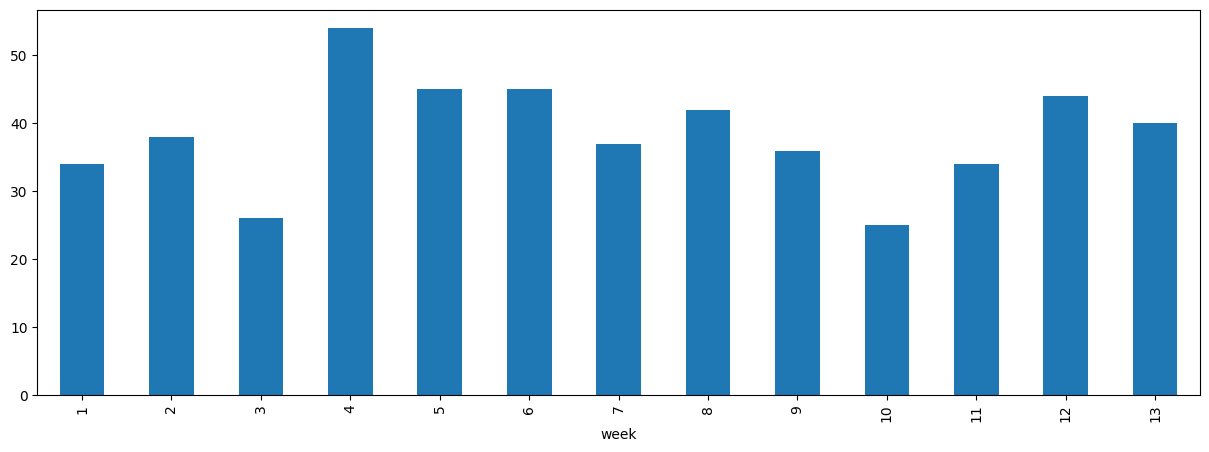

In [27]:
assignDates.startDate.dt.isocalendar().week.value_counts().sort_index().plot(kind='bar', figsize=(15, 5))